In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install torch torchvision albumentations opencv-python matplotlib
import os, random, math, time, copy, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import cv2, matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)


def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


def imshow(img, title=None):
    if torch.is_tensor(img): img = img.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(np.clip(img, 0, 1));
    if title: plt.title(title); plt.axis('off');
    plt.show()

Device: cuda


In [3]:
from torchvision.datasets import OxfordIIITPet

# Oxford-IIIT Pet có segmentation masks nếu split='trainval' &
target_types = 'segmentation'
root = "./data/pets"
os.makedirs(root, exist_ok=True)
tfm_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
tfm_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),  # giữ mask dạng [1,H,W] giá trị class-id
])


class PetSeg(Dataset):

    def __init__(self, train=True):
        split = 'trainval' if train else 'test'
        self.base = OxfordIIITPet(root, split=split, target_types='segmentation',
                                  download=True)
        # Tách train/test đơn giản
        n = len(self.base)
        idx = list(range(n))
        random.seed(0);
        random.shuffle(idx)
        cut = int(0.85 * n)
        self.ids = idx[:cut] if train else idx[cut:]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        img, mask = self.base[self.ids[i]]
        img = tfm_img(img)
        # mask chứa {1..3} cho background/border/object tùy spec dataset; chuẩn hóa về {0, 1}
        m = tfm_mask(mask).squeeze(0)  # [H,W]
        m = (m > 1).long()  # object(>1) là 1, còn lại 0 (binary semantic seg)
        return img, m


train_ds, val_ds = PetSeg(train=True), PetSeg(train=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0,
                          pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0,
                        pin_memory=True)
imgs, msks = next(iter(train_loader))
print("Batch:", imgs.shape, msks.shape, msks.unique())

100%|██████████| 792M/792M [00:36<00:00, 21.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.1MB/s]


Batch: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256]) tensor([0, 1])


In [4]:
def dice_loss(logits, targets, eps=1e-6):
    """
    Dice Loss for segmentation
    Args:
        logits: [B, C, H, W] - model output
        targets: [B, H, W] - ground truth labels
    """
    probs = F.softmax(logits, dim=1)
    num_classes = probs.shape[1]

    # Convert targets to one-hot
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    # Calculate dice coefficient for each class
    dice = 0
    for c in range(num_classes):
        pred_c = probs[:, c]
        target_c = targets_one_hot[:, c]

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        dice += (2 * intersection + eps) / (union + eps)

    return 1 - dice / num_classes

In [5]:
def evaluate(forward_fn, loader):
    """
    Evaluate model using mIoU metric
    Args:
        forward_fn: function để forward model
        loader: DataLoader
    Returns:
        mIoU: mean Intersection over Union
    """
    model.eval()
    iou_sum = 0
    count = 0

    with torch.no_grad():
        for img, msk in loader:
            img, msk = img.to(device), msk.to(device)
            logits = forward_fn(img)
            pred = torch.argmax(logits, dim=1)

            # Calculate IoU for each class
            for c in range(logits.shape[1]):
                pred_c = (pred == c)
                msk_c = (msk == c)

                intersection = (pred_c & msk_c).sum().item()
                union = (pred_c | msk_c).sum().item()

                if union > 0:
                    iou_sum += intersection / union
                    count += 1

    return iou_sum / max(count, 1)

In [17]:
num_classes = 2  # binary demo
model = torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT')
# thay head cho số lớp của mình
model.classifier[-1] = nn.Conv2d(256, num_classes, 1)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)


def forward_seg(img):
    out = model(img)['out']  # [B,C,H,W]
    return out


def train_epoch_torchvision(model, loader, opt):
    model.train()
    loss_sum = 0
    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)
        logits = forward_seg(img)
        loss = F.cross_entropy(logits, msk) + dice_loss(logits, msk)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item() * img.size(0)
        return loss_sum / len(loader.dataset)


for e in range(10):
    tr = train_epoch_torchvision(model, train_loader, opt)
    va = evaluate(lambda x: forward_seg(x), val_loader)  # dùng evaluate với wrapper
    print(f"[DeepLabV3] Epoch {e + 1}: loss={tr:.4f}, mIoU={va:.4f}")

[DeepLabV3] Epoch 1: loss=0.0036, mIoU=0.2557
[DeepLabV3] Epoch 2: loss=0.0032, mIoU=0.3677
[DeepLabV3] Epoch 3: loss=0.0029, mIoU=0.3981
[DeepLabV3] Epoch 4: loss=0.0028, mIoU=0.4248
[DeepLabV3] Epoch 5: loss=0.0025, mIoU=0.4811
[DeepLabV3] Epoch 6: loss=0.0026, mIoU=0.5277
[DeepLabV3] Epoch 7: loss=0.0024, mIoU=0.5677
[DeepLabV3] Epoch 8: loss=0.0022, mIoU=0.6041
[DeepLabV3] Epoch 9: loss=0.0023, mIoU=0.6283
[DeepLabV3] Epoch 10: loss=0.0019, mIoU=0.6513


In [20]:
def _denorm(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1).to(img.device)
    return img * std + mean

In [21]:
@torch.no_grad()
def viz_batch(model, loader, max_items=6):
    model.eval()
    imgs, msks = next(iter(loader))
    imgs = imgs[:max_items].to(device)
    msks = msks[:max_items].to(device)

    logits = model(imgs)['out']
    probs  = torch.softmax(logits, dim=1)[:,1:2]
    preds  = (probs>0.5).float()

    show_img  = _denorm(imgs).clamp(0,1).cpu()
    show_mask3= msks.unsqueeze(1).float().repeat(1,3,1,1).cpu()
    show_pred3= preds.cpu().repeat(1,3,1,1)

    # ép cùng HxW
    H,W = show_img.shape[-2:]
    if show_mask3.shape[-2:] != (H,W):
        show_mask3 = F.interpolate(show_mask3, size=(H,W), mode='nearest')
    if show_pred3.shape[-2:] != (H,W):
        show_pred3 = F.interpolate(show_pred3, size=(H,W), mode='nearest')

    grid = torch.cat([show_img, show_mask3, show_pred3], dim=0)
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(make_grid(grid, nrow=show_img.size(0)).permute(1,2,0))
    plt.show()

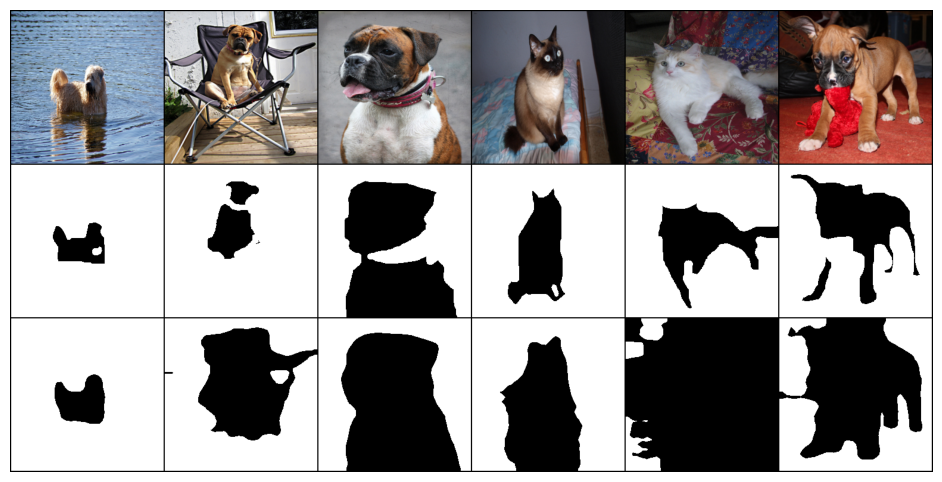

In [16]:
viz_batch(model, val_loader)